In [1]:
import morphct
import morphct.code.helperFunctions as hf
import pickle
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import freud
freud.parallel.setNumThreads(4)

# Fixes to deal with "old" morphCT data

from morphct.code import obtainChromophores
%matplotlib inline

In [13]:
def plot_rdf(a_pos, b_pos, sim_box, rmax,label):
    # frames is the number of frames you want to average over starting from
    # the last frame
    rdf = freud.density.RDF(rmax=rmax, dr=0.1)
    fbox = freud.box.Box(Lx=sim_box[0], Ly=sim_box[1], Lz=sim_box[2])
    rdf.accumulate(fbox, a_pos, b_pos)
                       
    r_avg = np.copy(rdf.getR())
    y_avg = np.copy(rdf.getRDF())
    plt.plot(r_avg, y_avg, label=label)
    plt.ylabel("g(r)")
    plt.xlabel("r")
    plt.legend()

def load_pickles(morph_name, main_path):
    morph_pickleFile = os.path.join(main_path,morph_name,"code/{}.pickle".format(morph_name))
    AAMorphologyDict, CGMorphologyDict, CGToAAIDMaster, parameterDict, chromophoreList = hf.loadPickle(morph_pickleFile)
    SimulationBox = np.array([AAMorphologyDict['lx'], AAMorphologyDict['ly'], AAMorphologyDict['lz']])
    kmc_pickle_path = os.path.join(main_path,morph_name,"KMC/KMCResults.pickle")
    with open(kmc_pickle_path, 'rb') as kmc_pickleFile:
        carrierData = pickle.load(kmc_pickleFile)
    return AAMorphologyDict, CGMorphologyDict, CGToAAIDMaster, parameterDict, chromophoreList, carrierData, SimulationBox

def data_to_plot(chromophoreList, SimulationBox, KMC, carrier):
    RandTI = np.zeros(3)
    for i, chrome in enumerate(chromophoreList):
        for neighbor in zip(chrome.neighbours, chrome.neighboursTI):
            index = neighbor[0][0]
            image = neighbor[0][1]
            TI = neighbor[1]

            vector = chrome.posn - chromophoreList[index].posn
            vector-=SimulationBox*image
            distance = np.linalg.norm(vector)
            
            if TI > 0.0:
                Hops = KMC[carrier][i,index]
                if Hops > 0 :
                    RandTI = np.vstack((RandTI, np.array([distance, np.log10(TI), np.log10(Hops)])))
    plotTIvR(RandTI[1:], carrier)
                    
def plotTIvR(array, carrier):
    plt.close()
    
    array = array[array[:,2].argsort()[::-1]]
    
    plasma = cm = plt.get_cmap('plasma')
    vmin = np.min(array[:,2])
    vmax = np.amax(array[:,2])
    cNorm = matplotlib.colors.Normalize(vmin=vmin, vmax = vmax)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=plasma)
    Hopcolors = scalarMap.to_rgba(array[:,2]) 
    Hopcolors /= np.amax(Hopcolors)
    
    plt.scatter(array[:,0], array[:,1], s = 20, c = Hopcolors)
    
    plt.xlabel(r"Distance ($\AA$)")
    plt.ylabel("ln(TI)")
    
    plt.title("Most Frequent Hops " + carrier, fontsize = 16)
    
    plt.legend(fontsize = 16, markerscale = 0)
    
    plt.show()
    

def generate_TI_and_hop_lists(chromophoreList):
    
    TI_list_donor = []
    TI_list_acceptor = []
    hops_list_donor = []
    hops_list_acceptor = []
    
    for i, chromo in enumerate(chromophoreList):
        for neighbor in zip(chromo.neighbours, chromo.neighboursTI):
            if chromo.species == "Donor":
                index = neighbor[0][0]
                image = neighbor[0][1]
                TI = neighbor[1]
                TI_list_donor.append(TI)
                hops_list_donor.append(carrierData["holeHistoryMatrix"][i,index])

            elif chromo.species == "Acceptor":
                index = neighbor[0][0]
                image = neighbor[0][1]
                TI = neighbor[1]
                TI_list_acceptor.append(TI)
                hops_list_acceptor.append(carrierData["electronHistoryMatrix"][i,index])
                
    return TI_list_donor, TI_list_acceptor, hops_list_donor, hops_list_acceptor

def generate_Kij_lists(AAMorphologyDict, chromophoreList):
    
    Kij_donor = []
    Kij_acceptor = []

    simDims = [[-AAMorphologyDict['lx'] / 2.0, AAMorphologyDict['lx'] / 2.0], [-AAMorphologyDict['ly'] / 2.0, AAMorphologyDict['ly'] / 2.0], [-AAMorphologyDict['lz'] / 2.0, AAMorphologyDict['lz'] / 2.0]]
    elementaryCharge = 1.60217657E-19 # C

    for chromo1 in chromophoreList:
        for index, neighbour in enumerate(chromo1.neighbours):
            # Only consider pairs X-Y where Y > X
            chromo2ID = neighbour[0]
            relativeImage = neighbour[1]
            #if chromo2ID < chromo1.ID:
            #    continue
            Tij = chromo1.neighboursTI[index]
            deltaE = chromo1.neighboursDeltaE[index]
            neighbourChromo = chromophoreList[chromo2ID]
            neighbourChromoPosn = neighbourChromo.posn + (np.array(relativeImage) * np.array([axis[1] - axis[0] for axis in simDims]))
            separation = hf.calculateSeparation(chromo1.posn, neighbourChromoPosn) * 1E-10 # Convert to m
            if (Tij is not None) and (deltaE is not None):
                Kij = hf.calculateCarrierHopRate(0.4*elementaryCharge, Tij*elementaryCharge, deltaE*elementaryCharge, 1.0, 290, useVRH=True, rij=separation)
                try:
                    CGIDs1 = chromo1.CGIDs
                    CGIDs2 = chromophoreList[chromo2ID].CGIDs
                except:
                    CGIDs1 = "UA input morphology has no CGIDs"
                    CGIDs2 = "UA input morphology has no CGIDs"
                #if Kij > 1E5:
                    #CSVData.append([str(chromo1.ID), str(chromo2ID), str(Kij), repr(CGIDs1), repr(CGIDs2)])
                if chromo1.species == "Donor":
                    Kij_donor.append(Kij)
                elif chromo1.species == "Acceptor":
                    Kij_acceptor.append(Kij)
                    
    return  Kij_donor, Kij_acceptor

def plot_TI_Kij_Hops(hops_list, TI_list, Kij_list, title):
    
    hops_array = np.array(hops_list)
    zero_hops_slice = np.nonzero(hops_array)
    
    vmin = np.min(hops_array[zero_hops_slice])
    vmax = np.amax(hops_array[zero_hops_slice])
    plasma = cm = plt.get_cmap('plasma')
    cNorm = matplotlib.colors.LogNorm(vmin=vmin, vmax = vmax)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=plasma)
    
    Hopcolors = scalarMap.to_rgba(hops_array[zero_hops_slice]) 
    plt.scatter(np.array(TI_list)[zero_hops_slice], np.log10(np.array(Kij_list)[zero_hops_slice]), c=Hopcolors)
    plt.xlabel("TI")
    plt.ylabel("Kij (log)")
    plt.title(title)
    plt.show()


def plot_chromo_rdf(chromophoreList):
    
    donor_com = []
    acceptor_com = []
    for chromo in chromophoreList:
        if chromo.species == "Donor":
            donor_com.append(chromo.posn)
        elif chromo.species == "Acceptor":
            acceptor_com.append(chromo.posn)

    donor_com = np.array(donor_com)
    acceptor_com = np.array(acceptor_com)
    plot_rdf(donor_com,donor_com, np.array(SimulationBox), 30, label="Donor")
    plot_rdf(acceptor_com,acceptor_com, np.array(SimulationBox), 30, label="Acceptor")

Loading Pickle from /home/mike/Data/blend/quantum/old_runs/fixed_mike-rig-qnch-dt0.001-phi0.916-e0.5-P1.0-N197-T7.0_AA/code/fixed_mike-rig-qnch-dt0.001-phi0.916-e0.5-P1.0-N197-T7.0_AA.pickle...
Pickle loaded successfully!


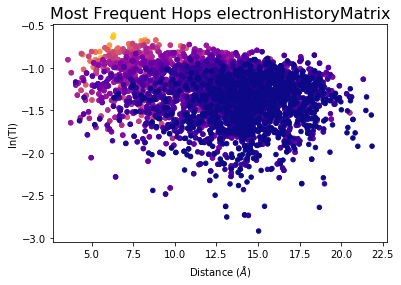

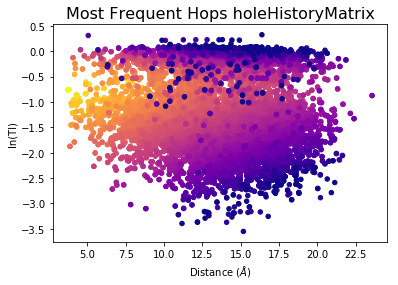

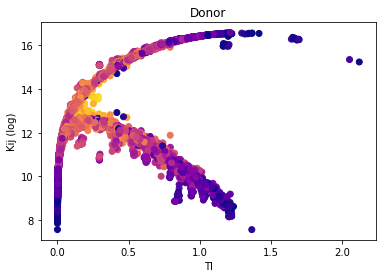

converting supplied array dtype float64 to dtype <class 'numpy.float32'>
converting supplied array dtype float64 to dtype <class 'numpy.float32'>
converting supplied array dtype float64 to dtype <class 'numpy.float32'>
converting supplied array dtype float64 to dtype <class 'numpy.float32'>


In [14]:
morph_name = "fixed_mike-rig-qnch-dt0.001-phi0.916-e0.5-P1.0-N197-T7.0_AA"
main_path = "/home/mike/Data/blend/quantum/old_runs"

AAMorphologyDict, CGMorphologyDict, CGToAAIDMaster, parameterDict, chromophoreList, carrierData, SimulationBox = load_pickles(morph_name, main_path)
data_to_plot(chromophoreList, SimulationBox, carrierData, "electronHistoryMatrix")
data_to_plot(chromophoreList, SimulationBox, carrierData, "holeHistoryMatrix")
TI_list_donor, TI_list_acceptor, hops_list_donor, hops_list_acceptor = generate_TI_and_hop_lists(chromophoreList)
Kij_donor, Kij_acceptor = generate_Kij_lists(AAMorphologyDict, chromophoreList)
plot_TI_Kij_Hops(hops_list_donor, TI_list_donor, Kij_donor, "Donor")
plot_TI_Kij_Hops(hops_list_acceptor, TI_list_acceptor, Kij_acceptor, "Acceptor")
plot_chromo_rdf(chromophoreList)